In [1]:
import pandas as pd
import numpy as np
from scipy.special import ndtri
from scipy.stats import norm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import interpolate
from scipy.interpolate import LinearNDInterpolator as LNDI
import itertools
from scipy.optimize import curve_fit

%precision 16

'%.16f'

We load the necessary data and structure it as desired:

In [2]:
#back out moneyness from delta
def inverse_delta(delta,tao,r,sigma):
    '''
    Calculate the moneyness of the option given: 
    - delta the BS delta, 
    - tao   time to expiry, 
    - sigma implied vol, 
    - r     interest rate.
    '''
    d1 = ndtri(delta)
    expr = d1 * sigma * np.sqrt(tao) - tao * (r + sigma**2 / 2)
    m = np.exp(-expr)
    return m

In [3]:
# Using forward slashes
volsurf_df = pd.read_csv("C:/Users/Usuario/Documents/MSc_Maths_Finance/Topics_in_Quantitative_Finance/coursework/Topics-in-Quant-Finance/implied vol with delta/implied vol with delta.csv")
zero_curve = pd.read_csv("C:/Users/Usuario/Documents/MSc_Maths_Finance/Topics_in_Quantitative_Finance/coursework/Topics-in-Quant-Finance/implied vol with delta/Zero Coupon Curve.csv")

#options with less than 10 days to expiry have no implied volatility calculated
volsurf_df = volsurf_df[(volsurf_df['days'] != 10) & (volsurf_df['days'] <= 365)] #shouldnt then this be <= 10 or use dropna
volsurf_df = volsurf_df.drop(columns=['index_flag','secid'])

#scale delta to be between 0 and 1
volsurf_df['delta'] = volsurf_df['delta']/100

#interest measured in percentage or basis points?
zero_curve['rate'] = zero_curve['rate']/100

volsurf_df = volsurf_df.drop('cp_flag', axis=1)
volsurf_df = volsurf_df.drop('ticker', axis=1)

impl_vol_sample = volsurf_df[volsurf_df['date']=='2021-12-31']

zero_curve_sample = zero_curve[zero_curve['date'] == '2021-12-31']
zero_curve_sample = zero_curve_sample[zero_curve_sample['days'].isin([30,60,91,122,152,182,273,365])]

impl_vol_sample = pd.merge(impl_vol_sample,zero_curve_sample[['days','rate']], how='left', left_on='days', right_on='days')

impl_vol_sample['moneyness']=impl_vol_sample.apply(lambda x: inverse_delta(x.delta,x.days/365,x.rate,x.impl_volatility),axis=1)

impl_vol_sample = impl_vol_sample.drop('rate', axis=1)
impl_vol_sample = impl_vol_sample.drop('delta', axis=1)
impl_vol_sample = impl_vol_sample.drop('date', axis=1)
impl_vol_sample['tau'] = impl_vol_sample['days']/365
impl_vol_sample = impl_vol_sample.drop('days', axis=1)

In [4]:
impl_vol_sample

,impl_volatility,moneyness,tau
0,0.106347,1.040784,0.082192
1,0.106598,1.033114,0.082192
2,0.108139,1.027378,0.082192
3,0.110721,1.022602,0.082192
4,0.114071,1.018286,0.082192
...,...,...,...
131,0.245869,0.912286,1.000000
132,0.263068,0.872906,1.000000
133,0.283304,0.825804,1.000000
134,0.307582,0.767530,1.000000


In the following cell we choose the parameters or our basis functions which are:
1) f1 is the level, constant value,
2) f2 is the skew of the surface, which depends only on moneyness linearly,
3) f3 is the curvature of the surface and is a quadratic polynomial in moneyness and linear in tau.

In [35]:
data = impl_vol_sample.to_numpy()

# Separate the data into separate arrays for m, tau, and vol
m_values = data[:, 1]
tau_values = data[:, 2]
vol_values = data[:, 0]

# Define the functions you want to fit to your data
def f2(x, a, b):
    return a*x + b

def f3(xy, a, b, c, d, e):
    x, y = xy
    return (a*x**2 + b*x + c) * (d*y + e) + -0.538764 * x + 0.535036 + f1_mean

# Calculate the mean of the vol values
f1_mean = np.mean(vol_values)

# Find the optimal fit for f1 using curve_fit
popt2, pcov2 = curve_fit(f2, m_values, vol_values)

# Find the optimal fit for f2 using curve_fit
popt3, pcov3 = curve_fit(f3, (m_values, tau_values), vol_values)



# Print the results
print("Mean of vol values or f1: {:.6f}".format(f1_mean))
print("Optimal fit for f2: {:.6f} * m + {:.6f}".format(*popt2))
print("Optimal fit for f3: ({:.6f} * m**2 + {:.6f} * m + {:.6f}) * ({:.6f} * tau + {:.6f})".format(*popt3))

Mean of vol values or f1: 0.185976
Optimal fit for f2: -0.538764 * m + 0.721013
Optimal fit for f3: (6.679758 * m**2 + -3.506755 * m + -2.079374) * (0.051438 * tau + -0.027467)


In [36]:
#Chosen basic functions:
def f1(m, tau): #level (it is not dependent of the parameters)
    return f1_mean

def f2(m, tau): #Skew (it is linear only on moneyness)
    return popt2[0] * m + popt2[1]

def f3(m, tau): #Curvature (linear in tau, quadratic in moneyness, product of splines)
    return (popt3[0] * m**2 + popt3[1] * m + popt3[2]) * (popt3[3] * tau + popt3[4])

In [37]:
max_tau = np.max(impl_vol_sample['tau'].unique())
min_tau = np.min(impl_vol_sample['tau'].unique())
max_moneyness = np.max(impl_vol_sample['moneyness'].unique())
min_moneyness = np.min(impl_vol_sample['moneyness'].unique())

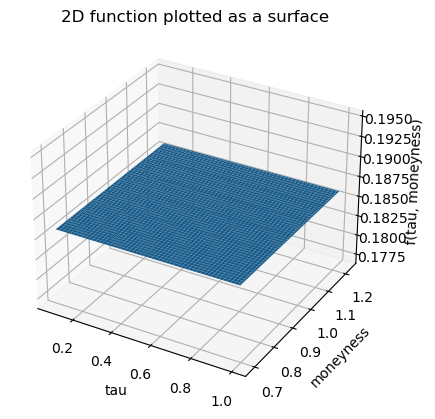

In [38]:
taus = np.linspace(min_tau, max_tau, 100)
moneyness = np.linspace(min_moneyness, max_moneyness, 100)
tau_mesh, moneyness_mesh = np.meshgrid(taus, moneyness)


# Evaluate the function on the grid
f1_values = np.array([[f1(t, k) for k in moneyness] for t in taus])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(tau_mesh, moneyness_mesh, f1_values)
ax.set_xlabel('tau')
ax.set_ylabel('moneyness')
ax.set_zlabel('f(tau, moneyness)')
ax.set_title('2D function plotted as a surface')
plt.show()

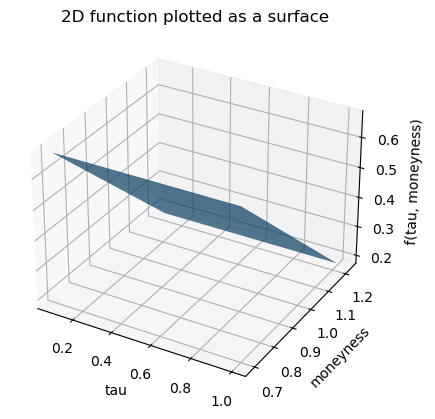

In [39]:
taus = np.linspace(min_tau, max_tau, 100)
moneyness = np.linspace(min_moneyness, max_moneyness, 100)
tau_mesh, moneyness_mesh = np.meshgrid(taus, moneyness)


# Evaluate the function on the grid
f2_values = np.array([[f2(t, k) for k in moneyness] for t in taus])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(tau_mesh, moneyness_mesh, f2_values)
ax.set_xlabel('tau')
ax.set_ylabel('moneyness')
ax.set_zlabel('f(tau, moneyness)')
ax.set_title('2D function plotted as a surface')
plt.show()

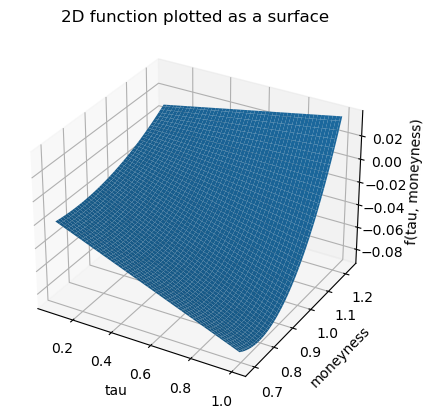

In [40]:
taus = np.linspace(min_tau, max_tau, 100)
moneyness = np.linspace(min_moneyness, max_moneyness, 100)
tau_mesh, moneyness_mesh = np.meshgrid(taus, moneyness)


# Evaluate the function on the grid
f3_values = np.array([[f3(t, k) for k in moneyness] for t in taus])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(tau_mesh, moneyness_mesh, f3_values)
ax.set_xlabel('tau')
ax.set_ylabel('moneyness')
ax.set_zlabel('f(tau, moneyness)')
ax.set_title('2D function plotted as a surface')
plt.show()

In [19]:
def call(m, tau, sigma, r):
    '''
    Function that retuns the price of a European Call given:
    - m     moneyness
    - tau   time to maturity
    - sigma volatility
    - r     interest rate
    '''
    d1 = (-np.log(m)+ tau * (r + sigma**2 / 2)) / (sigma * np.sqrt(tau))
    d2 = (-np.log(m)+ tau * (r - sigma**2 / 2)) / (sigma * np.sqrt(tau))
    return norm.cdf(d1) - m * np.exp(-r * tau) * norm.cdf(d2)


def surface(Xsim, f1, f2, f3, sigma0):
    """
    Parameters:

    Inside the lambda:
    - m a value of moneyness
    - tau a time to maturity

    Of the function:
    - Xsim a simulation of the path under chosen dynamics of the x's
    - f1(m, tau) all three are basis functions
    - f2(m, tau)
    - f3(m, tau)
    - sigma0 is a function of the initial volatility for m and tau
    Returns:
    - Volatility under the three factor model.
    """
    return lambda m, tau: sigma0(m, tau) * np.exp(Xsim[0] * f1(m, tau) + Xsim[1] * f2(m, tau) + Xsim[2] * f3(m, tau))


The following pieces of code simulate a path of $(S_t(w_i), \sigma_t(m,\tau,w_i);t\in \{0, \dots  t_{max}\})$ under the following dynamics:

$$X_t = (x_t^1, x_t^2, x^3_t)$$
a random vector in $R^3$ where the components represent the level, skew and curvature coefficients. 
Each coordinate is an independent Ornstein-Uhlenbeck procees:
$$dx_t^i=-\lambda^i x_t^i dt +\gamma^i dW_t^i$$

Under an Eurler Scheme:

The price of the underlying is modelled as:
$$dS_t = \sigma_t(1,0)dW_t^0$$
where $$W^0 = \rho W^1 + \sqrt{1-\rho^2} B$$

In [20]:
def simVECTORIALpath(N, lambdaVec, gammaVec, X_0Vect, sigma0, f1, f2, f3, S0, rho = -0.5):
    """
    This function simulates a joint path of the coefficient of the bassi functions together with a path for the underlying price
    Inputs:
    - N          number of periods to simulate the path in
    - lambdaVec  lambda parameters for the OU model
    - gammaVec   gamma parameters for the OU model
    - X_0Vec     a initial point to simulate the OU under an Euler scheme
    - rho        the correlation of the Brownian motions, the default is -0.5 as in the paper
    - f1         level basic function
    - f2         skew basic function
    - f3         curvature basic function
    - S0         a initial price of the underlying for the Euler scheme simulation, no default but normally take the price of
                the underlying the first day we have available data.

    Output:
    - Numpy array [S,X] being S the price process simulation and X the X process simulation.
    the shape is an array with N entries (periods) of dimension 4 being the first one for each period the pirce S_t.
    """


    h = 1 / 365 #We assume the jump between days is a calendar day distance to avoid over complications
    sqrth = np.sqrt(h)

    #We first generate the paths for the x^i_t
    X = np.zeros((N,3))
    # generates a N x 3 matrix of (0, 1) normals
    normals =  np.random.normal(size = (N, 3)) 
    X[0] = X_0Vect #Vector of initial values
    
    for n in range(1,N):
        X[n] = X[n-1] - lambdaVec * X[n-1] * h + gammaVec * normals[n-1] * sqrth


    #We now use the path to generate the implied vol surface sigma_t(m, tau)
    #In particular we need this to have sigma_t(1,0) to generate the asset path.

    sigma_1_0 = np.zeros(N)
    sigma_1_0[0] = sigma0

    for n in range(1,N):
        sigma_1_0[n] = sigma0 * np.exp(X[n,0]*f1(1, 0) + X[n,1]*f2(1, 0) +X[n,2]*f3(1, 0))
    
    #Now we simulate the Brownian motion that drives the asset:
    W = rho * normals[:,0] + np.sqrt(1-rho**2) * np.random.normal(size = N)

    #Finally we compute S_t:
    S = np.zeros(N)
    S[0] = S0
    for n in range(1,N):
        S[n] = S[n-1] + sigma_1_0[n] * W[n]

    result = np.concatenate((S[:, np.newaxis], X), axis=1)
    return result

We simulate paths.

We require the following parameters:

1)Number of paths we want to generate,

2)Number of days we want to generate the surfaces for,

3)Parameters of the OU dynamics Lambda, takend from paper [9] in the oroginal paper:
    R. Cont and J. da Fonseca, Dynamics of implied volatility surfaces, Quant. Finance, 2 (2002), pp. 45–60,

4)Parameters of the OU dynamics gamma taken from [9],

5)Initial point for the simulation of the X random vectors, we need 0 vector so that the       initial point fits the initial volatility used for the simulation,

6)Initial \sigma_0(1,0) needed to generate S_t path, we take f1,

7)Initial price of the underlying for the simulation, we will not use it for more than simulating joint dynamics.

8)rho is taken straight from the paper.

In [21]:
M = 3000                                    #Number of paths we want to generate
N = 60                                      #We generate a month of surfaces
lambdaVec = np.array([0.035, 0.08, 0.045])  #Parameters of the OU dynamics Lambda
gammaVec = 2 * np.sqrt( lambdaVec)          #Parameters of the OU dynamics gamma
X_0Vect = [0, 0, 0]                         #Initial point for the simulation of the X random vectors
sigma0 = 0.5                                #Initial \sigma_0(1,0) needed to generate S_t path
S0 = 100                                    #Initial price of the underlying for the simulation


#Implied volatility in the first period, we can take a empirical observed surface on a particular day and use it as a proxy 
def initial_surface(df):
    x = df['moneyness']
    y = df['tau']
    z = df['impl_volatility']
    f = interpolate.interp2d(x, y, z, kind='linear')
    return lambda moneyness, tau: f(moneyness, tau)[0]
    
sigma_0 = initial_surface(impl_vol_sample)

#Create the grid on which we want to construct the volatility
gridpoints = 10

moneyness = np.linspace(min_moneyness, max_moneyness, gridpoints)
taus = np.linspace(min_tau, max_tau, gridpoints)

#Create a joint grid
mgrid, tgrid = np.meshgrid(moneyness, taus, indexing='ij')


paths = []
for i in range(M):
    path =[]
    Xsim = simVECTORIALpath(N, lambdaVec, gammaVec, X_0Vect, sigma0, f1, f2, f3, S0, rho = -0.5)
    for n in range(len(Xsim)):
        sigma_t = surface([Xsim[n,1], Xsim[n,2], Xsim[n,3]], f1, f2, f3, sigma_0)
        triples = []
        for m in moneyness:
            for tau in taus:
                triples.append([m, tau, sigma_t(m, tau)])

        triples = np.array(triples)
        path.append([Xsim[n,0], triples, n])
    paths.append(path)

c:\Users\Usuario\anaconda3\lib\site-packages\scipy\interpolate\_fitpack_impl.py:977: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=20,10 m=136 fp=0.000001 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


##In the following cells we develop the reweighting approach for Montecarlo simulations, giving lower weights to the penalised paths. The bigger the static arbitrage present, the bigger penalization.

A path is a realization of the evolution of the volatility surface:
$$(S_t(w_i), \sigma_t(m,\tau,w_i);t\in \{0, \dots  t_{max}\})$$
under the measure $\mathbb{P}_0$ (physical dynamics). 

Once we have a simulation of $N$ paths we add a weight to each path as following:
$$w_i(\beta):= \frac{exp(-\beta \phi(w_i))}{\sum_{j=1}^N exp(-\beta \phi(w_j))}$$

In [22]:
X = np.array(paths, dtype=object)
r = 0.07                            #We choose constant interest rate
beta = 1.40                         #Penalization coefficient

# Create an empty dataframe with desired columns
df = pd.DataFrame(columns=['omega', 'time', 'S_t', 'moneyness', 'tau', 'Vol_t'])
print(type(df))

#We make it a dataframe, it is not the most efficient method, but it is comprenhensible and still works for nt very bug simulations. 
# Flatten the multi-dimensional array using list comprehension
rows = [{'omega': i+1, 'time': X[i][j][2], 'S_t': X[i][j][0], 'moneyness': X[i][j][1][k][0], 'tau': X[i][j][1][k][1], 'Vol_t': X[i][j][1][k][2]} 
        for i in range(len(X)) for j in range(len(X[i])) for k in range(len(X[i][j][1]))]

# Create a data frame from the list of dictionaries
df = pd.DataFrame.from_records(rows)

# Sort the dataframe by omega, moneyness, and tau
df = df.reindex(columns=['omega', 'time', 'S_t', 'tau','moneyness',  'Vol_t']) #for convenience this order is better
df = df.sort_values(['omega','time','tau', 'moneyness'])


#We calculate this distance: (in this case 0.1)
tau_values = df['tau'].unique()
jumpt = tau_values[1] - tau_values[0]

m_values = df['moneyness'].unique()
jumpm = m_values[1] - m_values[0]

#Compute the penalties:
df['p1'] = df['tau'] * (call(df['moneyness'], df['tau'], df['Vol_t'], r)-call(df['moneyness'], df['tau']+jumpt, df['Vol_t'], r)) /(jumpt)
df['p2'] = (call(df['moneyness']+jumpm, df['tau'], df['Vol_t'], r)-call(df['moneyness'], df['tau'], df['Vol_t'], r)) /(jumpm)
df['p3'] = (call(df['moneyness'], df['tau'], df['Vol_t'], r)-call(df['moneyness']-jumpm, df['tau'], df['Vol_t'], r)) /(jumpm) - (call(df['moneyness']+jumpm, df['tau'], df['Vol_t'], r)-call(df['moneyness'], df['tau'], df['Vol_t'], r)) /(jumpm)

#We only take as penalties the positive values:
df['p1'] = df['p1'].apply(lambda x: max(0, x))
df['p2'] = df['p2'].apply(lambda x: max(0, x))
df['p3'] = df['p3'].apply(lambda x: max(0, x))


#We need to make 0 those values that should not have a penalty by 
#the indexing and have been computing in the previous way for simplicity:

# Update the value of p1 to 0 where tau is maximum
max_tau = np.max(tau_values)
df.loc[df['tau'] == max_tau, 'p1'] = 0

# Update the value of p2 to 0 where the indexing needs it to:
max_m= np.max(m_values)
df.loc[df['moneyness'] == max_m, 'p2'] = 0

# Update the value of p3 to 0 where the indexing needs it to:
second_index = m_values[0]
df.loc[df['moneyness'] == max_m, 'p3'] = 0
df.loc[df['moneyness'] == second_index, 'p3'] = 0


#After fixing the indexing:
df['totalpen'] = df['p1'] + df['p2'] + df['p3']

#Group the DataFrame by the 'omega' column and sum the 'p1', 'p2', and 'p3' columns
grouped_df = df.groupby('omega')['totalpen'].sum()
grouped_df = np.exp(- beta * grouped_df)
weights = grouped_df / (grouped_df.sum())

<class 'pandas.core.frame.DataFrame'>


In [23]:
grouped = df.groupby(['time', 'tau', 'moneyness'])

In [24]:
def weighted_avg(group):
    w = weights[group['omega'].values]
    return pd.Series({
        'S_t': np.average(group['S_t'], weights=w),
        'Vol_t': np.average(group['Vol_t'], weights=w)
    })

In [25]:
def avg(group):
    return pd.Series({
        'S_t': np.average(group['S_t']),
        'Vol_t': np.average(group['Vol_t'])
    })

In [26]:
MC = grouped.apply(avg).reset_index()
WMC = grouped.apply(weighted_avg).reset_index()

In [28]:
df = MC

#We calculate this distance: (in this case 0.1)
tau_values = df['tau'].unique()
jumpt = tau_values[1] - tau_values[0]

m_values = df['moneyness'].unique()
jumpm = m_values[1] - m_values[0]

#Compute the penalties:
df['p1'] = df['tau'] * (call(df['moneyness'], df['tau'], df['Vol_t'], r)-call(df['moneyness'], df['tau']+jumpt, df['Vol_t'], r)) /(jumpt)
df['p2'] = (call(df['moneyness']+jumpm, df['tau'], df['Vol_t'], r)-call(df['moneyness'], df['tau'], df['Vol_t'], r)) /(jumpm)
df['p3'] = (call(df['moneyness'], df['tau'], df['Vol_t'], r)-call(df['moneyness']-jumpm, df['tau'], df['Vol_t'], r)) /(jumpm) - (call(df['moneyness']+jumpm, df['tau'], df['Vol_t'], r)-call(df['moneyness'], df['tau'], df['Vol_t'], r)) /(jumpm)

#We only take as penalties the positive values:
df['p1'] = df['p1'].apply(lambda x: max(0, x))
df['p2'] = df['p2'].apply(lambda x: max(0, x))
df['p3'] = df['p3'].apply(lambda x: max(0, x))


#We need to make 0 those values that should not have a penalty by 
#the indexing and have been computing in the previous way for simplicity:

# Update the value of p1 to 0 where tau is maximum
max_tau = np.max(tau_values)
df.loc[df['tau'] == max_tau, 'p1'] = 0

# Update the value of p2 to 0 where the indexing needs it to:
max_m= np.max(m_values)
df.loc[df['moneyness'] == max_m, 'p2'] = 0

# Update the value of p3 to 0 where the indexing needs it to:
second_index = m_values[0]
df.loc[df['moneyness'] == max_m, 'p3'] = 0
df.loc[df['moneyness'] == second_index, 'p3'] = 0


#After fixing the indexing:
df['totalpen'] = df['p1'] + df['p2'] + df['p3']


In [29]:
df['totalpen'].sum()

1.1324274851176597e-13

In [30]:
df = WMC

#We calculate this distance: (in this case 0.1)
tau_values = df['tau'].unique()
jumpt = tau_values[1] - tau_values[0]

m_values = df['moneyness'].unique()
jumpm = m_values[1] - m_values[0]

#Compute the penalties:
df['p1'] = df['tau'] * (call(df['moneyness'], df['tau'], df['Vol_t'], r)-call(df['moneyness'], df['tau']+jumpt, df['Vol_t'], r)) /(jumpt)
df['p2'] = (call(df['moneyness']+jumpm, df['tau'], df['Vol_t'], r)-call(df['moneyness'], df['tau'], df['Vol_t'], r)) /(jumpm)
df['p3'] = (call(df['moneyness'], df['tau'], df['Vol_t'], r)-call(df['moneyness']-jumpm, df['tau'], df['Vol_t'], r)) /(jumpm) - (call(df['moneyness']+jumpm, df['tau'], df['Vol_t'], r)-call(df['moneyness'], df['tau'], df['Vol_t'], r)) /(jumpm)

#We only take as penalties the positive values:
df['p1'] = df['p1'].apply(lambda x: max(0, x))
df['p2'] = df['p2'].apply(lambda x: max(0, x))
df['p3'] = df['p3'].apply(lambda x: max(0, x))


#We need to make 0 those values that should not have a penalty by 
#the indexing and have been computing in the previous way for simplicity:

# Update the value of p1 to 0 where tau is maximum
max_tau = np.max(tau_values)
df.loc[df['tau'] == max_tau, 'p1'] = 0

# Update the value of p2 to 0 where the indexing needs it to:
max_m= np.max(m_values)
df.loc[df['moneyness'] == max_m, 'p2'] = 0

# Update the value of p3 to 0 where the indexing needs it to:
second_index = m_values[0]
df.loc[df['moneyness'] == max_m, 'p3'] = 0
df.loc[df['moneyness'] == second_index, 'p3'] = 0


#After fixing the indexing:
df['totalpen'] = df['p1'] + df['p2'] + df['p3']


In [31]:
df['totalpen'].sum()

1.1324274851176597e-13

In [32]:
total = np.exp(- beta * df.groupby('omega')['totalpen'].sum()).sum()
(np.exp(- beta * df.groupby('omega')['totalpen'].sum())/total).sort_values()

KeyError: 'omega'

In [298]:
beta = 1.59

#Group the DataFrame by the 'omega' column and sum the 'p1', 'p2', and 'p3' columns
grouped_df = df.groupby('omega')['totalpen'].sum()
grouped_df = np.exp(- beta * grouped_df)
total = grouped_df.sum()
weights = grouped_df / (total)
weights.max()-weights.min()

1.0000000000000000